In [2]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [5]:
#Importamos el dataset de restaurant final
restaurants = pd.read_parquet('https://storage.googleapis.com/restaurants_datalake/restaurants.parquet')
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171419 entries, 0 to 171418
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Id_Restaurant        171419 non-null  object 
 1   Nombre               171419 non-null  object 
 2   Ciudad               171419 non-null  object 
 3   Estado               171419 non-null  object 
 4   Cod_postal           171419 non-null  object 
 5   Latitud              171419 non-null  float64
 6   Longitud             171419 non-null  float64
 7   Tipo                 171419 non-null  object 
 8   Ambiente             171419 non-null  int64  
 9   Para_grupos          171419 non-null  int64  
 10  Promociones          171419 non-null  int64  
 11  Estacionamiento      171419 non-null  int64  
 12  Inclusivo            171419 non-null  int64  
 13  Comodidades          171419 non-null  int64  
 14  Exteriores           171419 non-null  int64  
 15  Atencion_comida  

In [6]:
#Importamos todo el dataset de reviews 
reviews = pd.read_parquet('https://storage.googleapis.com/restaurants_datalake/restaurants.parquet')
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16007867 entries, 0 to 16007866
Data columns (total 5 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   Cod_Usuario    int32 
 1   Id_Restaurant  object
 2   Rating         int64 
 3   Reseña         object
 4   Timestamp      Int64 
dtypes: Int64(1), int32(1), int64(1), object(2)
memory usage: 564.9+ MB


Para realizar el modelo de Machine Learning no nos interesan ni las reseñas (el texto), ni el momento en el que se hizo la misma (Timestamp). Vamos a descartar estas columnas para trabajar con un dataframe mas liviano.

In [7]:
reviews_ml = reviews.drop(columns=['Reseña','Timestamp'])
reviews_ml.head()

,Cod_Usuario,Id_Restaurant,Rating
0,0,0x8889221157fb3455:0x5c125c40c3eccc2a,4
1,0,0x888922179fedc577:0xb066d794085a5647,4
2,0,0x888923a5bb7652f7:0x29bfa66c33b8d370,3
3,0,0x888923bccd6a2787:0x2a9a298802d0b047,5
4,0,0x888923bb2d078e43:0x8bfd401337be51ca,5


Vamos a observar las características de los distintos campos

<AxesSubplot: xlabel='Rating', ylabel='count'>

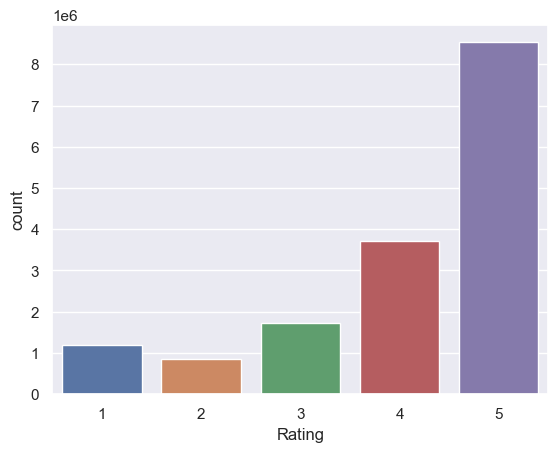

In [8]:
#Vamos a observar como están distribuidas las calificaciones
sns.countplot(data=reviews_ml,x='Rating')

Puede verse que el dataset esta claramente desbalanceado. La suma de las cantidades de todas las otras calificiones (de 1 a 4) no llega a la cantidad de calificación 5. Mientras que la suma de las calificaciones 4 y 5 es mas del triple que de las calificaciones mas bajas (1 a 3). Antes de realizar alguna acción correctiva vamos a seguir explorando.

In [9]:
#Agrupamos las reviews por usuario y contamos cuantas veces voto cada uno
usuarios_agrupados = reviews_ml.groupby(by='Cod_Usuario').count().drop(
                                                columns='Id_Restaurant').rename(
                                                    columns={'Rating':'Cantidad'}).sort_values(
                                                                    by='Cantidad',ascending=False).reset_index()
usuarios_agrupados

,Cod_Usuario,Cantidad
0,5593234,1704
1,5593039,1296
2,5816479,1144
3,5592928,1104
4,5597225,1095
...,...,...
7038632,3084837,1
7038633,3084836,1
7038634,3084835,1
7038635,3084834,1


<AxesSubplot: >

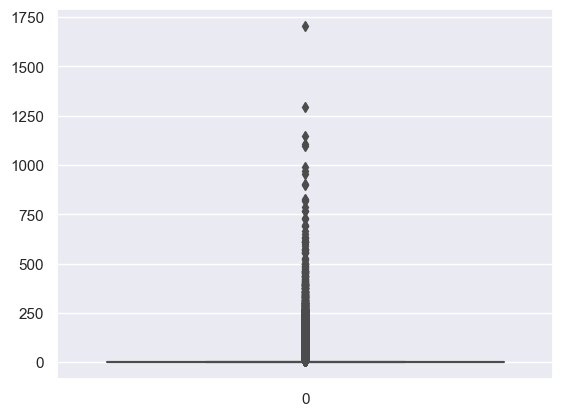

In [10]:
#Visualizamos estas cantidades
sns.boxplot(data=usuarios_agrupados['Cantidad'])

(0.0, 5.0)

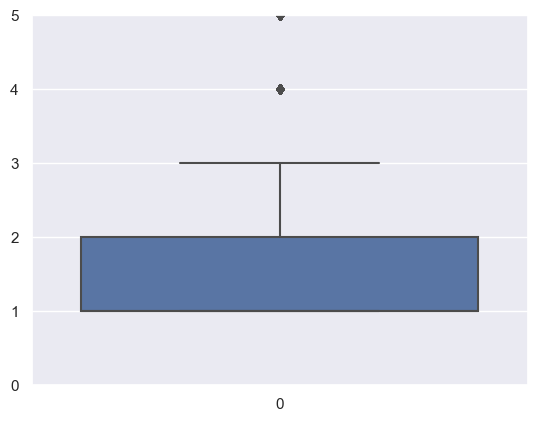

In [11]:
#Nos acercamos a la media
sns.boxplot(data=usuarios_agrupados['Cantidad'])
plt.ylim(0,5)

In [12]:
usuarios_agrupados[usuarios_agrupados['Cantidad']==1].shape

(3872331, 2)

Vemos que son demasiados los usuarios (casi 4 millones) que nos dan demasiada poca información ya que votaron una única vez. Igual que con el desbalanceo vamos a esperar a terminar de analizar el resto del dataset antes de hacer alguna acción correctiva.

In [13]:
#Agrupamos las reviews por restaurant y contamos cuantos votos tiene cada uno
restaurants_agrupados = reviews_ml.groupby(by='Id_Restaurant').count().drop(
                                                columns='Cod_Usuario').rename(
                                                    columns={'Rating':'Cantidad'}).sort_values(
                                                                    by='Cantidad',ascending=False).reset_index()
restaurants_agrupados

,Id_Restaurant,Cantidad
0,0x8620a60c5d5e55d3:0x73c7b3c06a67a923,9057
1,ac1AeYqs8Z4_e2X5M3if2A,7508
2,0x40771e59f0513085:0x513683476a2005d8,7148
3,GXFMD0Z4jEVZBCsbPf4CTQ,6149
4,ytynqOUb3hjKeJfRj5Tshw,5770
...,...,...
171414,4QdZHOqo7OI63SG6JnLdpg,5
171415,4Qt-KtFm3AJOJnrk61_7JQ,5
171416,i0b_xiKIbExKtF3vqo1Bzw,5
171417,bfVvm2RsdDW8AReCM9ii8A,5


<AxesSubplot: >

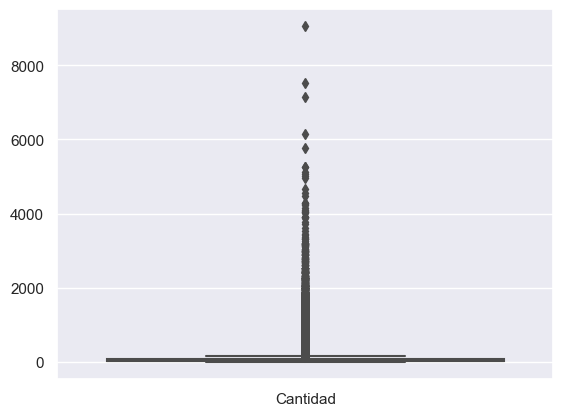

In [14]:
#Visualizamos estas cantidades
sns.boxplot(data=restaurants_agrupados)

(0.0, 200.0)

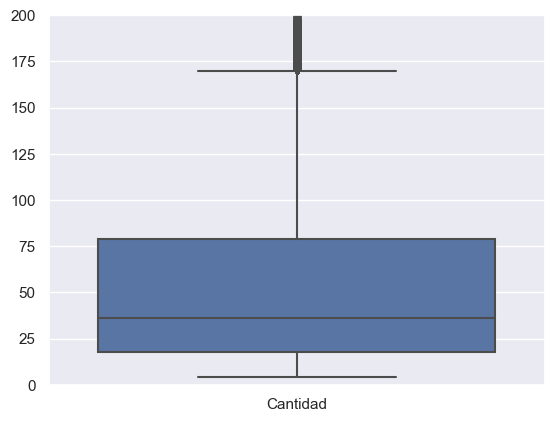

In [15]:
#Nos acercamos
sns.boxplot(data=restaurants_agrupados)
plt.ylim(0,200)

Se ven grandes outliers con restaurants que recibieron una gran cantidad de reseñas y una gran cantidad que recibieron 4 o 5 reseñas. Al no estar comparando items si no que vamos a comparar usuarios y vamos a hacer perfiles de estos, el hecho de que algún restaurant tenga muchas reseñas o pocas no interfiere con el aprendizaje.

Naturalmente, los restaurants con muchas reseñas van a ser más veces recomendados que los otros pero esto no es un problema si no una salida natural a este problema.

Por lo tanto, los restaurants vamos a dejarlos así. Sin embargo, para los usuarios que nos dieron tan poca información es dificil armarle un perfil y esto traerá grandes errores en el modelo de ML. Debemos eliminarlos para evitarlos.

In [16]:
#Vemos cuantos usuarios votaron menos de 5 veces
print('Usuarios con menos de 5 votos: ',usuarios_agrupados[usuarios_agrupados['Cantidad']<5].shape[0])
print('Porcentaje del total: ',
      round(100*usuarios_agrupados[usuarios_agrupados['Cantidad']<5].shape[0]/usuarios_agrupados.shape[0],2),'%')

Usuarios con menos de 5 votos:  6449015
Porcentaje del total:  91.62 %


Si establecemos un minimo de 5 votos para poder armar un perfil de usuario como para recomendar debemos descartar más del 90% de los usuarios. Esto no quiere decir que se descartará más del 90% del dataset pero si se va a descartar al menos la mitad del mismo. Todo esto se realiza en pos de un buen funcionamiento del modelo.

In [17]:
reviews_ml_filt = reviews_ml[~reviews_ml['Cod_Usuario'].isin(usuarios_agrupados[
                                                usuarios_agrupados['Cantidad']<5].index)].reset_index(drop=True)
reviews_ml_filt

,Cod_Usuario,Id_Restaurant,Rating
0,0,0x8889221157fb3455:0x5c125c40c3eccc2a,4
1,0,0x888922179fedc577:0xb066d794085a5647,4
2,0,0x888923a5bb7652f7:0x29bfa66c33b8d370,3
3,0,0x888923bccd6a2787:0x2a9a298802d0b047,5
4,0,0x888923bb2d078e43:0x8bfd401337be51ca,5
...,...,...,...
1253540,589618,0x80c2910469186fa1:0xe289a3896a6ca31c,5
1253541,589619,0x80c2910469186fa1:0xe289a3896a6ca31c,5
1253542,589620,0x80c2910469186fa1:0xe289a3896a6ca31c,5
1253543,589620,0x80c2902caa0abfc9:0x95e5628910c65ae9,5


<AxesSubplot: xlabel='Rating', ylabel='count'>

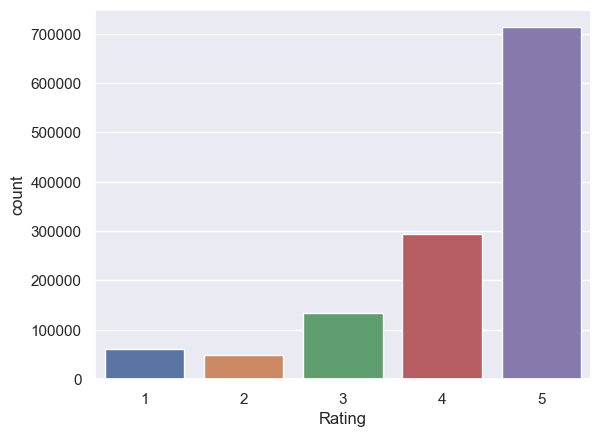

In [18]:
#Se descartó mas de 2/3 del dataset. Vamos a ver si la distribución de las calificaciones cambió
sns.countplot(data=reviews_ml_filt,x='Rating')

Se ve que cambió bastante. La diferencia entre las calificaciones de 5 y las demás ya no es tan grande. Igualmente sigue considerablemente desbalanceado pero así se va a trabajar. Presentamos un breve resumen a continuación.

In [19]:
print('Cantidad de restaurants antes de quitar los usuarios que votaron poco: ',reviews_ml['Id_Restaurant'].unique().size)
print('Cantidad de restaurants luego de quitar los usuarios que votaron poco: ',reviews_ml_filt['Id_Restaurant'].unique().size)

Cantidad de restaurants antes de quitar los usuarios que votaron poco:  171419
Cantidad de restaurants luego de quitar los usuarios que votaron poco:  64444


In [20]:
print('Cantidad de usuarios antes de quitar los que votaron poco: ',reviews_ml['Cod_Usuario'].unique().size)
print('Cantidad de usuarios luego de quitar los que votaron poco: ',reviews_ml_filt['Cod_Usuario'].unique().size)

Cantidad de usuarios antes de quitar los que votaron poco:  7038637
Cantidad de usuarios luego de quitar los que votaron poco:  589622


In [21]:
print('Cantidad de reviews antes de quitar los usuarios que votaron poco:')
print(reviews_ml.shape[0])
print('Distribucion:')
print('5: ',reviews_ml[reviews_ml['Rating']==5].shape[0])
print('4: ',reviews_ml[reviews_ml['Rating']==4].shape[0])
print('3: ',reviews_ml[reviews_ml['Rating']==3].shape[0])
print('2: ',reviews_ml[reviews_ml['Rating']==2].shape[0])
print('1: ',reviews_ml[reviews_ml['Rating']==1].shape[0])
print('Cantidad de reviews luego de quitar los usuarios que votaron poco:')
print(reviews_ml_filt.shape[0])
print('Distribucion:')
print('5: ',reviews_ml_filt[reviews_ml_filt['Rating']==5].shape[0])
print('4: ',reviews_ml_filt[reviews_ml_filt['Rating']==4].shape[0])
print('3: ',reviews_ml_filt[reviews_ml_filt['Rating']==3].shape[0])
print('2: ',reviews_ml_filt[reviews_ml_filt['Rating']==2].shape[0])
print('1: ',reviews_ml_filt[reviews_ml_filt['Rating']==1].shape[0])

Cantidad de reviews antes de quitar los usuarios que votaron poco:
16007867
Distribucion:
5:  8536468
4:  3704381
3:  1722892
2:  856264
1:  1187862
Cantidad de reviews luego de quitar los usuarios que votaron poco:
1253545
Distribucion:
5:  713074
4:  294977
3:  134983
2:  48652
1:  61859


Finalmente exportamos y subimos los archivos. Luego de observar que registros se necesitan para el análisis de las reseñas (visto en procesamiento de reseñas) y para realizar el modelo de predicción vamos a exportar únicamente estos dataframes de manera que solamente importemos luego solamente estos también.

In [42]:
#Exportamos en formato parquet el archivo filtrado de reviews para el modelo de ML
reviews_ml_filt.to_parquet('reviews_ml.parquet',index=False)

Finalmente subimos el dataset a Google Cloud

In [1]:
#Importamos librerías
from google.cloud import storage
import os

In [2]:
#Definimos credenciales
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'D:/Marcos/Clave GCP/vaulted-aleph-382723-3f77bc5470a3.json'

In [3]:
#Creamos cliente de GCS
client = storage.Client()

In [4]:
#Llamamos a nuestro datalake
bucket = client.get_bucket('restaurants_datalake')

In [ ]:
#Subimos las reviews para el modelo de machine learning
blob_ml = bucket.blob('reviews_ml.parquet')
blob_ml.upload_from_filename('reviews_ml.parquet')